In [192]:
%matplotlib inline
import scipy as sc
import numpy as np
from numpy import random
from scipy.optimize import minimize


## Generate sample data

### Generate the raw data at time t0

In [367]:
random.seed(1)
n = 5000
likeMean = 100

# At time t0
# We assume Comment count and Share count are roughly 50% and 20% of Like count
X1a = random.normal(likeMean, 20, n)  # Like count
X2a = random.normal(int(likeMean * 0.5), 10, n)  # Comment count
X3a = random.normal(int(likeMean * 0.2), 2, n)  # Share count
Xa = np.stack((X1a, X2a, X3a), axis=-1)

### Then we generate the raw data at time t1

In [419]:
# Assume a proportion of the threads are rising sharply
hotProportion = 0.9
isHot = random.uniform(low=0, high=1, size=n) > hotProportion

# For ease of debugging
isHot[0] = True

# All activities will rise by 25%
baseIncrBy = np.maximum(0, random.normal(0.25, 0.1, size=n))

# For "Hot" threads, Comment and Share will raise by an extra 25%
extraIncrBy = np.maximum(0, isHot * random.normal(0.25, 0.1, size=n))

#totalIncrBy = 1 + baseIncrBy + extraIncrBy

In [420]:
X1b = X1a*(1+baseIncrBy)
X2b = X2a*(1 + baseIncrBy + extraIncrBy)
X3b = X3a*(1 + baseIncrBy + extraIncrBy)

In [421]:
# Raw data at time t1
#Xb = (Xa.T * totalIncrBy).T
Xb = np.stack((X1b, X2b, X3b), axis=-1)

#### Inspect the generated data

In [422]:
# First 20 rows of Xa
Xa[:10,:]

array([[ 132.48690727,   40.75244716,   19.75505219],
       [  87.76487173,   61.28889895,   20.45633964],
       [  89.43656495,   38.71208731,   19.29538974],
       [  78.54062756,   42.75262378,   18.33889311],
       [ 117.30815259,   56.23571209,   19.47782037],
       [  53.96922606,   64.37966464,   20.33870846],
       [ 134.89623528,   52.74141843,   21.3472462 ],
       [  84.77586198,   44.95530985,   19.34559679],
       [ 106.38078192,   61.06670996,   19.38940171],
       [  95.01259249,   56.93304105,   21.04973066]])

In [423]:
# First 20 values of isHot
isHot[0:10]

array([ True, False, False, False, False,  True, False, False, False, False], dtype=bool)

In [424]:
# First 20 rows of Xb
Xb[:10,:]

array([[ 179.46723899,   63.87688497,   30.96479559],
       [ 113.77377184,   79.45171079,   26.5185247 ],
       [ 103.60459385,   44.84463469,   22.35205498],
       [ 106.9957935 ,   58.24184308,   24.98304994],
       [ 148.4574833 ,   71.16821895,   24.64984853],
       [  80.08885117,  113.38105563,   35.81914022],
       [ 152.77434434,   59.7313602 ,   24.17644595],
       [ 117.21751021,   62.15860705,   26.74868337],
       [ 139.70174394,   80.19423926,   25.46261819],
       [ 124.77400387,   74.76654723,   27.6432745 ]])

### We assume our popularity score is a function with the below form

In [425]:
def popularity(v, b0, b1, b2, b3, b4):
    return b0*v[0] + b1*v[1] + b2*v[2] + b3*(v[1]**2) + b4*(v[2]**2)

### Let's assume that the True weights of the popularity score is as specified below

In [438]:
def truePop(v):
    return popularity(v, 1, 2, 2, 0.5, 0.5)

### Based on the "true popularity score", what will be the slope of our raw data between t0 and t1?

In [439]:
popXa = np.apply_along_axis(truePop, 1, Xa)
popXb = np.apply_along_axis(truePop, 1, Xb)
popSlope = popXb / popXa

In [440]:
# Inspect
popSlope[0:10]

array([ 3.8349723 ,  2.17668115,  1.55202286,  2.52270717,  2.02464776,
        5.45619076,  1.45146503,  2.63792657,  2.26256802,  2.26233727])

### Assume that the True cutoff point is at the 90-th percentile.  Based on that, we can generate our true labels.

In [441]:
# Assume that the true cutoff point for being considered as popular is the 90-th percentile
trueBoundary = 90
boundary = np.percentile(popSlope, [trueBoundary])[0]

In [442]:
trueY = popSlope >= boundary

In [443]:
# Inspect
trueY[:10]

array([ True, False, False, False, False,  True, False, False, False, False], dtype=bool)

In [444]:
# trueY and iHot should be very close
np.mean(trueY == isHot)

0.93999999999999995

### Now we define the loss function we want to optimize.  We try two loss functions, one based on f1-score, and the other based on accuracy.

In [445]:
from sklearn.metrics import f1_score, accuracy_score

def lossBase(B):
    global Xa, Xb
    popXa = np.apply_along_axis(popularity, 1, Xa, B[0], B[1], B[2], B[3], B[4])
    popXb = np.apply_along_axis(popularity, 1, Xb, B[0], B[1], B[2], B[3], B[4])
    popSlope = popXb / popXa

    p = B[5]
    if p < 0:
        p = 0
        
    if p > 100:
        p = 100
        
    boundary = np.percentile(popSlope, [p])[0]
    y = popSlope >= boundary
    return y

# f1-score based loss function
def loss(B):
    # f1_score returns 1 for the best result
    return 1 - f1_score(trueY, lossBase(B))

# accuracy based loss function
def loss_acc(B):
    # accuracy_score returns 1 if everything matches
    return 1 - accuracy_score(trueY, lossBase(B))
                

In [447]:
loss([1,2,2,0.5,0.5,90])

0.0

In [448]:
loss([1,2,2,3,3,85])

0.19999999999999996

In [449]:
loss([1,1,1,0,0,90])

0.35399999999999998

In [451]:
loss([1,1,1,1,1,90])

0.0020000000000000018

In [450]:
loss([1,2,2,0,0,90])

0.23199999999999998

## Use PSO

http://pythonhosted.org/pyswarm/

http://mnemstudio.org/particle-swarm-introduction.htm

In [452]:
from pyswarm import pso


In [453]:
lb = [1,0,0,0,0, 50]
ub = [1.1,10,10,10,10, 100]

In [454]:
xopt, fopt = pso(loss, lb, ub, maxiter=15)

Stopping search: maximum iterations reached --> 15


In [455]:
print xopt
print fopt

[  1.03127635   3.7354408    3.5642359    0.7486199    2.11695929
  89.9790525 ]
0.000999000999001


In [456]:
xopt2, fopt2 = pso(loss_acc, lb, ub, maxiter=15)

Stopping search: maximum iterations reached --> 15


In [457]:
print xopt2
print fopt2

[  1.01142342   6.3756275    2.04653676   0.73864037   0.55005288
  90.00398128]
0.0


## Use skopt

https://scikit-optimize.github.io/

In [458]:
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.plots import plot_convergence

B0 = [[1., 1.1], [0, 10.], [0, 10.], [0, 10.], [0, 10.], [50., 100.]]
X0 = [1., 0., 0., 0., 0., 50.]

In [459]:
res = gp_minimize(loss, B0, x0=X0)
print res.x
print res.fun

[1.0380545663017617, 0, 7, 3, 10, 90.008192020503216]
0.002


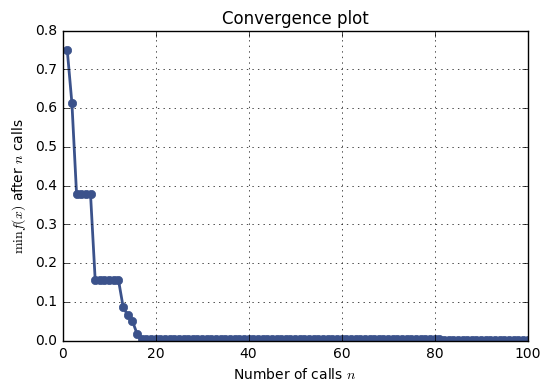

In [460]:
plot_convergence(res)

In [461]:
res2 = gp_minimize(loss_acc, B0, x0=X0)
print res2.x
print res2.fun

[1.1000000000000001, 10, 7, 4, 8, 89.973657310101743]
0.0004


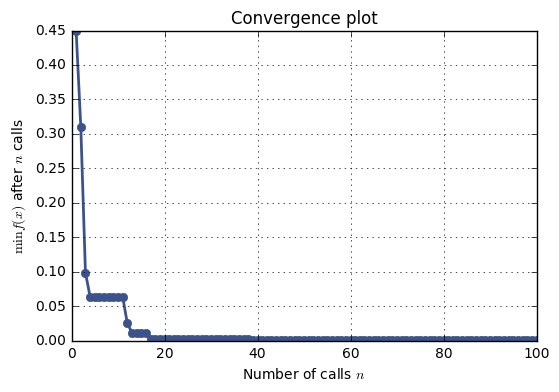

In [462]:
plot_convergence(res2)

In [463]:
res3 = forest_minimize(loss_acc, dimensions=B0, x0=X0)
print res3.x
print res3.fun

[1.0639569359223422, 6, 7, 6, 8, 89.98027399937952]
0.0006


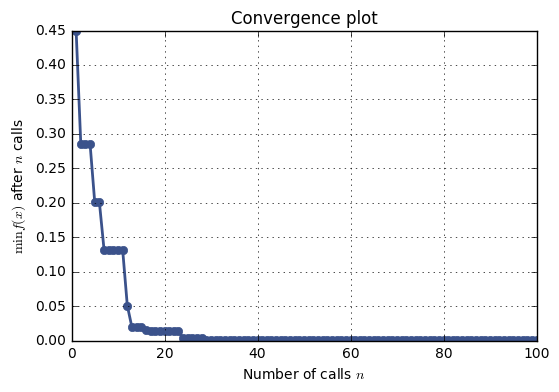

In [464]:
plot_convergence(res3)

In [465]:
res4 = forest_minimize(loss_acc, dimensions=B0, x0=X0, base_estimator="RF")
print res4.x
print res4.fun

[1.0462316645209191, 3, 9, 3, 5, 90.036928006304151]
0.0006


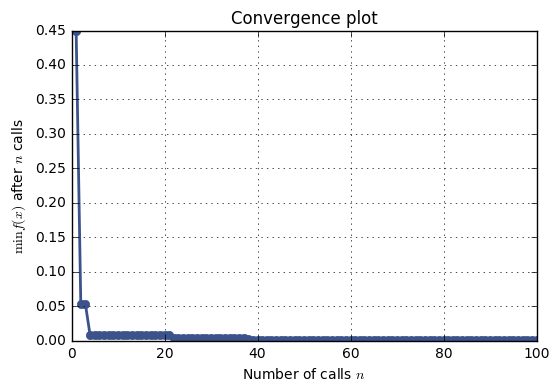

In [466]:
plot_convergence(res4)

In [467]:
res5 = gbrt_minimize(loss_acc, dimensions=B0, x0=X0)
print res5.x
print res5.fun

[1.0983946138710239, 9, 8, 5, 4, 90.010482952709879]
0.0004


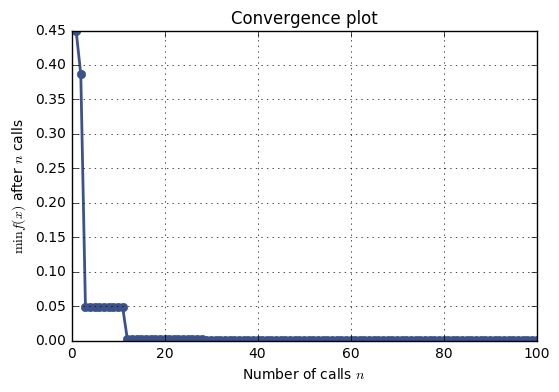

In [468]:
plot_convergence(res5)